In [1]:
%matplotlib notebook
import xemc3
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import numpy as np

# EMC3 data reading

In [2]:
felix_folder = "/u/flr/data/EMC3-runs/W7X/EIM-SC/EFFENBERG"
# seperatrix density
# input power in seperatrix
# impurity transport coefficient
# radiation fraction of input power
# impurity type
experiment = "N03.00_P05.00_D05_R02.00-C"
# "N03.00_P05.00_D05_C04.50-TEST"  # "N04.00_P02.50_D05_R02.00-N"  # 
#ds = xemc3.load.all(f"{felix_folder}/{experiment}")
# ds.to_netcdf(f"{experiment}.nc")

In [3]:
# everything (including geometry data)
ds = xr.open_dataset(f"../atomdatpy/NetCDFs-new/{experiment}.nc")
# Ez only (only useful with precalculated xemc3 geom matrix)
#ds = xr.open_dataset(f"../atomdatpy/NetCDFs/{experiment}_Ez.nc")

In [4]:
ds["Ezsum"] = ds["Ez"].sum(dim="Ionization", skipna=False)

In [5]:
bolotype = "QRB"
ds_gabr = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
sightlines = ds_gabr.los
sightline_names = ds_gabr.id

In [6]:
sightlines[0]

<xarray.DataArray 'los' (hit: 2, xyz: 3)>
array([[-5.456615, -2.206791, -1.016647],
       [-6.603495, -2.344544,  1.752051]])
Dimensions without coordinates: hit, xyz

In [7]:
def crossec_pcolorgrid(ds, phi):
    # (A+1)*(B+1) = AB + A + B +1
    outR = np.empty((len(ds["r"])+1, len(ds["theta"])+1))
    outZ = outR.copy()
    
    outR[:-1,:-1] = ds["R_bounds"][ :, :,phi,0,0,0]  # AB
    outR[:-1, -1] = ds["R_bounds"][ :,-1,phi,0,1,0]  # A
    outR[ -1,:-1] = ds["R_bounds"][-1, :,phi,1,0,0]  # B
    outR[ -1, -1] = ds["R_bounds"][-1,-1,phi,1,1,0]  # 1
    
    outZ[:-1,:-1] = ds["z_bounds"][ :, :,phi,0,0,0]  # AB
    outZ[:-1, -1] = ds["z_bounds"][ :,-1,phi,0,1,0]  # A
    outZ[ -1,:-1] = ds["z_bounds"][-1, :,phi,1,0,0]  # B
    outZ[ -1, -1] = ds["z_bounds"][-1,-1,phi,1,1,0]  # 1
    
    return outR, outZ

def combination_plot(bolo_name="AEE", bolo_index=0, bolo_type="QSB", prec=1000, sf = lambda x: np.log(x+1e-4)):
    ds["Ezsum"] = ds["Ez"].sum(dim="Ionization", skipna=False)
    ds["Ezsum"][:20] = 0
    ds_gabr = xr.open_dataset(f"../Gabriele/{bolo_type}-dataset.nc")
    sightlines = ds_gabr.los
    sightline_names = ds_gabr.id
    
    # find foil index
    full_name = f"{bolo_name} Foil {bolo_index}"
    index = np.nonzero((sightline_names == full_name).values)[0][0]
    
    
    A, B = sightlines[index][0].values, sightlines[index][1].values
    X = np.linspace(A[0], B[0], prec)
    Y = np.linspace(A[1], B[1], prec)
    Z = np.linspace(A[2], B[2], prec)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,7))
    ds["Eztemp"] = ds["Ezsum"]
    dir_vec = (B - A)/np.linalg.norm(B - A)
    pos_vecs = np.array([X,Y,Z]).T - A
    length = np.einsum("i,ji", dir_vec, pos_vecs) # in m

    # get mapping
    mapped = ds.emc3.evaluate_at_xyz(
        X, Y, Z, 
        key=None,
        periodicity=5, updownsym=True, delta_phi=np.pi / 1800
    )
    
    mapped.coords["dr"] = length
    mapped.dr.attrs = dict(units="m", long_name="length in space")
    
    m = mapped.assign(Ezsum=ds.Ezsum[mapped])
    m = m.assign(Ez=ds.Ez[mapped])
    
    # plot 1
    axs[0].plot(m["dr"], m["Ezsum"], c="grey", lw=2, zorder=100, label="total $E_Z$")
    for i in range(7):
        axs[0].plot(m["dr"], m["Ez"][i], label=f"$E_Z^{i}$")
    axs[0].set_title("Emissivity along sightline")
    axs[0].set_ylabel("$E_Z$ in $W/m^3$")
    axs[0].set_xlabel("coordinate along sightline in m")
    axs[0].legend()
    
    # plot 2
    ds["Ezcoloring"] = sf(ds["Ezsum"])
    #sightline_phi = np.searchsorted(ds["phi_bounds"][:,1], np.arctan2(A[1], A[0]) % (2*np.pi/10))
    fma = np.arctan2(A[1], A[0]) % (2*np.pi/5) # full module angle
    hmma = fma if fma < np.pi/5 else 2*np.pi/5 - fma # half module mapped angle
    hmma_index = np.searchsorted(ds.phi_bounds[:,1], hmma)
    is_flipped = fma > (2*np.pi/5 - fma)
    
    R,Z = crossec_pcolorgrid(ds, hmma_index)
    C = ds["Ezcoloring"].isel(phi=hmma_index)
    axs[1].fill(R[0], Z[0], c="k")
    axs[1].pcolormesh(R, Z, C, cmap=mpl.cm.magma)
    
    r_sightline = np.array([(A[0]**2+A[1]**2)**(1/2),(B[0]**2+B[1]**2)**(1/2)])
    z_sightline = np.array([A[2], B[2]])
    if is_flipped:
        z_sightline *= -1
    
    axs[1].set_aspect("equal")
    axs[1].axes.xaxis.set_ticklabels([])
    axs[1].axes.yaxis.set_ticklabels([])
    axs[1].axes.xaxis.set_visible(False)
    axs[1].axes.yaxis.set_visible(False)
    axs[1].plot(r_sightline, z_sightline, c="C1", zorder=1000, lw=2)
    axs[1].set_ylim((-1.2,1.2))
    axs[1].set_xlim((4.5,6.6))
    
    #fig.tight_layout()
    return fig, axs, m, length

In [8]:
#axs[0].set_yscale("log")
#axs[0].set_yscale("linear")

<IPython.core.display.Javascript object>


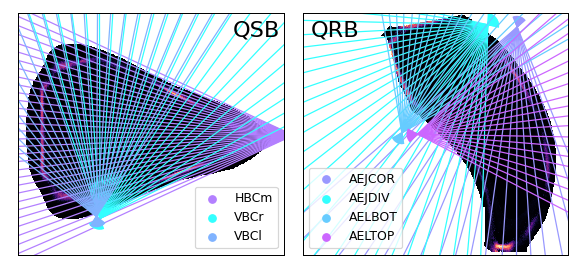

In [16]:
fig, axs = plt.subplots(figsize=(6.5,3.0), ncols=2)

if True: # QSB
    hmma_index = 35
    ds_gabr = xr.open_dataset(f"../Gabriele/QSB-dataset.nc")
    sightlines = ds_gabr.los
    sightline_names = ds_gabr.id
    # find foil index
    sf = lambda x: np.log(x+1e5)
    ds["Ezsum"][:20] = 0
    ds["Ezcoloring"] = sf(ds["Ezsum"])

    R,Z = crossec_pcolorgrid(ds, hmma_index)
    C = ds["Ezcoloring"].isel(phi=hmma_index)
    axs[0].fill(R[0], Z[0], c="k")
    axs[0].pcolormesh(R, Z, C, cmap=mpl.cm.magma)
    axs[0].set_aspect("equal")
    axs[0].axes.xaxis.set_ticklabels([])
    axs[0].axes.yaxis.set_ticklabels([])
    axs[0].axes.xaxis.set_visible(False)
    axs[0].axes.yaxis.set_visible(False)
    axs[0].set_ylim(-.9,0.92) # 1.82
    axs[0].set_xlim(4.4,6.4)  # 2
    axs[0].text(6.368, 0.86, "QSB", ha="right", va="top", size=18)
    
    bolotype = "QSB"
    A_all = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
    color_dict = {"HBCm Foi": (0.7, 0.5, 1.0), "VBCr Foi": (0.2, 1.0, 1.0), "VBCl Foi": (0.5, 0.7, 1.0), 
                  "AEJCOR F": (0.6, 0.6, 1.0), "AEJDIV F": (0.2, 1.0, 1.0), 
                  "AELBOT F": (0.4, 0.8, 1.0), "AELTOP F": (0.8, 0.4, 1.0)}
    colors = [color_dict[s.data[()][:8]] for s in A_all.id]

    already = []
    for i, (foil, color, label) in enumerate(zip(A_all.los, colors, [s.data[()][:4] for s in A_all.id])):
        A, B = foil.isel(hit=0), foil.isel(hit=1)
        r_sightline = np.array([(A[0]**2+A[1]**2)**(1/2),(B[0]**2+B[1]**2)**(1/2)])
        z_sightline = np.array([A[2], B[2]])
        fma = np.arctan2(A[1], A[0]) % (2*np.pi/5) # full module angle
        is_flipped = fma > (2*np.pi/5 - fma)
        if label == "HBCm":
            is_flipped = False
        if is_flipped:
            z_sightline *= -1
        if label not in already:
            axs[0].scatter([1000], [1000], color=color, label=label)
            already.append(label)
        axs[0].plot(r_sightline, z_sightline, c=color, lw=1)
    axs[0].legend(loc=4)
    
if True: # QRB
    hmma_index = 13
    ds_gabr = xr.open_dataset(f"../Gabriele/QRB-dataset.nc")
    sightlines = ds_gabr.los
    sightline_names = ds_gabr.id
    # find foil index
    sf = lambda x: np.log(x+1e5)
    ds["Ezsum"][:20] = 0
    ds["Ezcoloring"] = sf(ds["Ezsum"])


    R,Z = crossec_pcolorgrid(ds, hmma_index)
    C = ds["Ezcoloring"].isel(phi=hmma_index)
    axs[1].fill(R[0], Z[0], c="k")
    axs[1].pcolormesh(R, Z, C, cmap=mpl.cm.magma)
    axs[1].set_aspect("equal")
    axs[1].axes.xaxis.set_ticklabels([])
    axs[1].axes.yaxis.set_ticklabels([])
    axs[1].axes.xaxis.set_visible(False)
    axs[1].axes.yaxis.set_visible(False)
    axs[1].set_ylim(-.77,1.05) # 1.82
    axs[1].set_xlim(4.3,6.3) # 2
    axs[1].text(4.36, 0.99, "QRB", ha="left", va="top", size=18)
    
    bolotype = "QRB"
    A_all = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
    color_dict = {"HBCm Foi": (0.7, 0.5, 1.0), "VBCr Foi": (0.2, 1.0, 1.0), "VBCl Foi": (0.5, 0.7, 1.0), 
                  "AEJCOR F": (0.6, 0.6, 1.0), "AEJDIV F": (0.2, 1.0, 1.0), 
                  "AELBOT F": (0.4, 0.8, 1.0), "AELTOP F": (0.8, 0.4, 1.0)}
    colors = [color_dict[s.data[()][:8]] for s in A_all.id]

    already = []
    for i, (foil, color, label) in enumerate(zip(A_all.los, colors, [s.data[()][:6] for s in A_all.id])):
        A, B = foil.isel(hit=0), foil.isel(hit=1)
        r_sightline = np.array([(A[0]**2+A[1]**2)**(1/2),(B[0]**2+B[1]**2)**(1/2)])
        z_sightline = np.array([A[2], B[2]])
        fma = np.arctan2(A[1], A[0]) % (2*np.pi/5) # full module angle
        is_flipped = fma > (2*np.pi/5 - fma)
        if is_flipped:
            z_sightline *= -1
        if label not in already:
            axs[1].scatter([1000], [1000], color=color, label=label)
            already.append(label)
        axs[1].plot(r_sightline, z_sightline, c=color, lw=1)

    axs[1].legend(loc=3)

fig.tight_layout()

fig.savefig("./plots/sightline-fans.pdf")
fig.savefig("./plots/sightline-fans.png", dpi=200)

<IPython.core.display.Javascript object>


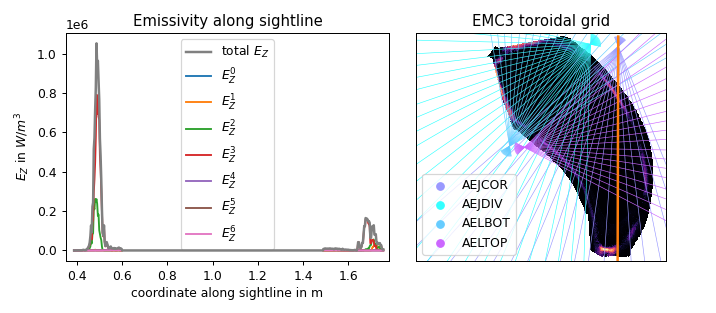

In [11]:
fig, axs, *_ = combination_plot(bolo_name="AEJCOR", bolo_index=7, bolo_type="QRB", sf = lambda x: np.log(x+1e5))
fig.set_size_inches(8, 3.5, forward=True)
#axs[0].legend(loc=1)
axs[1].set_ylim(-.77,1.05) # 1.82
axs[1].set_xlim(4.3,6.3) # 2
#axs[0].set_xlim(0.65, 1.09)
axs[1].set_title("EMC3 toroidal grid")
axs[0].set_xlim((0.35, 1.78))
fig.tight_layout()

bolotype = "QRB"
A_all = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
color_dict = {"HBCm Foi": (0.7, 0.5, 1.0), "VBCr Foi": (0.2, 1.0, 1.0), "VBCl Foi": (0.5, 0.7, 1.0), 
              "AEJCOR F": (0.6, 0.6, 1.0), "AEJDIV F": (0.2, 1.0, 1.0), 
              "AELBOT F": (0.4, 0.8, 1.0), "AELTOP F": (0.8, 0.4, 1.0)}
colors = [color_dict[s.data[()][:8]] for s in A_all.id]

already = []
for i, (foil, color, label) in enumerate(zip(A_all.los, colors, [s.data[()][:6] for s in A_all.id])):
    A, B = foil.isel(hit=0), foil.isel(hit=1)
    r_sightline = np.array([(A[0]**2+A[1]**2)**(1/2),(B[0]**2+B[1]**2)**(1/2)])
    z_sightline = np.array([A[2], B[2]])
    fma = np.arctan2(A[1], A[0]) % (2*np.pi/5) # full module angle
    is_flipped = fma > (2*np.pi/5 - fma)
    if is_flipped:
        z_sightline *= -1
    if label not in already:
        axs[1].scatter([1000], [1000], color=color, label=label)
        already.append(label)
    axs[1].plot(r_sightline, z_sightline, c=color, lw=0.5)

axs[1].legend(loc=3)
fig.tight_layout()
fig.savefig("./plots/sightlineintegral2.pdf")
fig.savefig("./plots/sightlineintegral2.png", dpi=200)

<IPython.core.display.Javascript object>


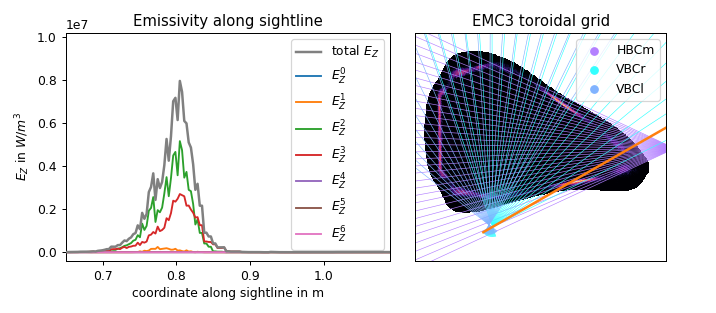

In [17]:
fig, axs, *_ = combination_plot(bolo_name="VBCr", bolo_index=2, bolo_type="QSB", sf = lambda x: np.log(x+1e5))
fig.set_size_inches(8, 3.5, forward=True)
# axs[0].legend(loc=1)
axs[1].set_ylim(-.9,0.92) # 1.82
axs[1].set_xlim(4.4,6.4)  # 2
axs[0].set_xlim(0.65, 1.09)
axs[1].set_title("EMC3 toroidal grid")
axs[0].set_ylim((axs[0].get_ylim()[0], 10.2e6))
fig.tight_layout()

bolotype = "QSB"
A_all = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
color_dict = {"HBCm Foi": (0.7, 0.5, 1.0), "VBCr Foi": (0.2, 1.0, 1.0), "VBCl Foi": (0.5, 0.7, 1.0), 
              "AEJCOR F": (0.6, 0.6, 1.0), "AEJDIV F": (0.2, 1.0, 1.0), 
              "AELBOT F": (0.4, 0.8, 1.0), "AELTOP F": (0.8, 0.4, 1.0)}
colors = [color_dict[s.data[()][:8]] for s in A_all.id]

already = []
for i, (foil, color, label) in enumerate(zip(A_all.los, colors, [s.data[()][:4] for s in A_all.id])):
    A, B = foil.isel(hit=0), foil.isel(hit=1)
    r_sightline = np.array([(A[0]**2+A[1]**2)**(1/2),(B[0]**2+B[1]**2)**(1/2)])
    z_sightline = np.array([A[2], B[2]])
    fma = np.arctan2(A[1], A[0]) % (2*np.pi/5) # full module angle
    is_flipped = fma > (2*np.pi/5 - fma)
    if label == "HBCm":
            is_flipped = False
    if is_flipped:
        z_sightline *= -1
    if label not in already:
        axs[1].scatter([1000], [1000], color=color, label=label)
        already.append(label)
    axs[1].plot(r_sightline, z_sightline, c=color, lw=0.5)


axs[1].legend(loc=1)
fig.tight_layout()
fig.savefig("./plots/sightlineintegral.pdf")
fig.savefig("./plots/sightlineintegral.png", dpi=200)

In [15]:
ds_gabr.Etendue[33] * 1e7

<xarray.DataArray 'Etendue' ()>
array(0.03065094)

<IPython.core.display.Javascript object>


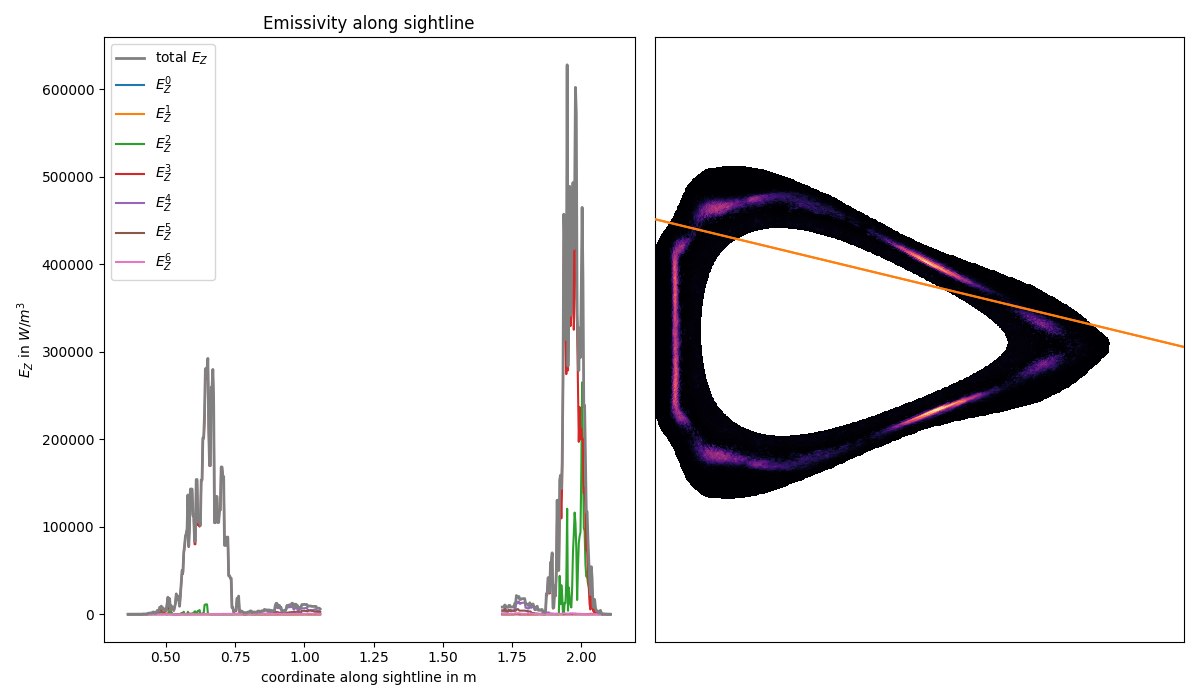

In [16]:
fig, axs, *_ = combination_plot(bolo_name="HBCm", bolo_index=25, bolo_type="QSB", sf = lambda x: np.log(x+1e5))

# change in relevant sightlines for changing diffusion coeff

In [8]:
import xemc3
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import xarray as xr
import numpy as np
import ipywidgets as widgets
import mpl_interactions.ipyplot as iplt
from pathlib import Path
from brokenaxes import brokenaxes

philip_folder =  "/u/phg/adas/atomdatpy/NetCDFs-new"
experiment_folder = "N03.00_P05.00_D05_R02.00-C"
plotfolder = "./plots"

dsdir = Path("../atomdatpy/NetCDFs-new/")
paths = (sorted(dsdir.glob("N03.00_P05.00_D02_R0*"), reverse=True))[:]
cpaths = paths[:5]
diff_paths = [paths[-3], paths[-1], paths[-2]]
all_paths = [*cpaths[:-1], *diff_paths]
interesting_paths = [cpaths[0], cpaths[2], cpaths[4], *diff_paths]

In [9]:
def integrated(ds, orig, hit, prec=1000, only_sum=False):
    A, B = orig, hit
    X = np.linspace(A[0], B[0], prec)
    Y = np.linspace(A[1], B[1], prec)
    Z = np.linspace(A[2], B[2], prec)
    
    # calculate line pos
    dir_vec = (B - A)/np.linalg.norm(B - A)
    pos_vecs = np.array([X,Y,Z]).T - A.data
    length = np.einsum("i,ji", dir_vec, pos_vecs) # in m
    stepsize = (length[-1] - length[0])/len(length)
    # get mapping
    mapped = ds.emc3.evaluate_at_xyz(
        X, Y, Z, 
        key=None,
        periodicity=5, updownsym=True, delta_phi=np.pi / 1800
    )
    
    mapped.coords["dr"] = length
    mapped.dr.attrs = dict(units="m", long_name="length in space")
    
    m = mapped.assign(Ezsum=ds.Ezsum[mapped] * stepsize)
    m = m.assign(Ez=ds.Ez[mapped] * stepsize)
        
    return m

In [10]:
# QSB
bolotype = "QSB"
A_all = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
relevant_QSB = slice(20,32)
A_labels_QSB = A_all.id[relevant_QSB]
A_labels_QSB = [f"{' '.join(name.split(' ')[:-1])} {int(name.split(' ')[-1]):02d}" for name in A_labels_QSB.data]
A_orig_QSB = A_all.los[:,0][relevant_QSB]
A_hits_QSB = A_all.los[:,1][relevant_QSB]
A_etendue_QSB = A_all.Etendue[relevant_QSB]

# QRB
bolotype = "QRB"
A_all = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
relevant_QRB = slice(37, 48)
A_labels_QRB = A_all.id[relevant_QRB]
A_labels_QRB = [f"{' '.join(name.split(' ')[:-1])} {int(name.split(' ')[-1]):02d}" for name in A_labels_QRB.data]
A_orig_QRB = A_all.los[:,0][relevant_QRB]
A_hits_QRB = A_all.los[:,1][relevant_QRB]
A_etendue_QRB = A_all.Etendue[relevant_QRB]

In [11]:
QRB_all, QSB_all = dict(), dict()
for path in cpaths:
    ds = xr.open_dataset(path)
    ds["Ezsum"] = ds.Ez.sum(dim="Ionization")
    
    abs_power_density_sum_QSB = np.zeros((len(A_labels_QSB,)))
    abs_power_density_QSB = np.zeros((len(A_labels_QSB),len(ds.Ionization)))
    for i, (orig, hit) in enumerate(zip(A_orig_QSB, A_hits_QSB)):
        print(i, end=", ")
        p = integrated(ds, orig, hit, only_sum=False)
        abs_power_density_sum_QSB[i] = p.sum().Ezsum
        abs_power_density_QSB[i] = p.Ez.sum("dim_0")

    abs_power_density_sum_QRB = np.zeros((len(A_labels_QRB,)))
    abs_power_density_QRB = np.zeros((len(A_labels_QRB),len(ds.Ionization)))
    for i, (orig, hit) in enumerate(zip(A_orig_QRB, A_hits_QRB)):
        print(i, end=", ")
        p = integrated(ds, orig, hit, only_sum=False)
        abs_power_density_sum_QRB[i] = p.sum().Ezsum
        abs_power_density_QRB[i] = p.Ez.sum("dim_0")
        
    QSB_all[path.stem] = abs_power_density_sum_QSB
    QRB_all[path.stem] = abs_power_density_sum_QRB

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

In [12]:
def get_color(f, d):
    d2 = np.sqrt((10*d-2)/8)
    r = cm.magma( (f-0.4)*1.8 )
    s = tuple((1-d2)*rr + d2*0.6 for rr in r)
    #print(f,d,d2,r,s)
    return s

<IPython.core.display.Javascript object>


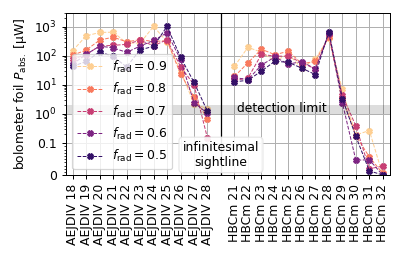

In [18]:
fig, ax = plt.subplots(figsize=(4.5,2.9))

total_label = [*A_labels_QRB, *A_labels_QSB]

total_label = [s[:-8] + s[-3:] for s in total_label]
tmp_x = np.array(range(1+len(total_label)))
tmp_x_tick = [*tmp_x[:len(A_labels_QRB)], *tmp_x[-len(A_labels_QSB):]]
mW_fac = 1000e3

for cpath in cpaths:
    sum_QSB = QSB_all[cpath.stem] * A_etendue_QSB
    sum_QRB = QRB_all[cpath.stem] * A_etendue_QRB
    total_integrated = np.array([*sum_QRB, *sum_QSB])
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    label="$f_{\mathrm{rad}} =$" + str(frad)
    col=get_color(frad, diffval)
    
    y = mW_fac*total_integrated
    ax.errorbar(tmp_x, [*y[:len(A_labels_QRB)], np.nan, *y[-len(A_labels_QSB):]], color=col, fmt="X--", ms=4.5,
               label=label, lw=0.8)
    

ax.set_xticks(tmp_x_tick)
ax.set_xticklabels(total_label, rotation=90)
ax.set_xlim(-0.5, len(total_label)+0.5)
# ax.set_title(f"Calculated absorbed {bolotype} foil power and relative error of absorbed power calculated by the sightline approach.")
# ax.set_ylabel("Collected Power in $\mathrm{mW}$")
#ax.legend(loc=1)
ax.set_yscale("symlog", linthresh=1e-1)
ax.set_ylim((0,3e3))
ax.vlines(len(A_labels_QRB), 0, 1e9, color="k", lw=1)
ax.set_ylabel("bolometer foil $P_{\mathrm{abs.}}$ [$\mathrm{\mu W}$]")
#plt.yticks(rotation = 90, ha="center", va="center")
ax.set_yticks([0,0.1,1,10,100,1000])
ax.set_yticks([*np.linspace(0,0.1,11), *np.linspace(0.1,1,10), *np.linspace(1,10,10),
               *np.linspace(10,100,10), *np.linspace(100,1000,10), 2000, 3000], minor=True)
ax.set_yticklabels(["0", "0.1", "$10^0$", "$10^1$", "$10^2$", "$10^3$"])

fig.tight_layout()
ax.grid()
ax.legend()

bbox_props = dict(boxstyle="round", fc="w", ec="0.9", alpha=0.9)
ax.text(11, 0.02, "infinitesimal\nsightline", ha="center", va="bottom", bbox=bbox_props)

ax.axhspan(1, 2, facecolor=(*(0.0,)*3, 2/15) , zorder=3)
ax.text(12.2, 0.9, "detection limit", ha="left", va="bottom")

fig.savefig(f"./plots/sightline_integration_frad_variation.png")
fig.savefig(f"./plots/sightline_integration_frad_variation.pdf")

<IPython.core.display.Javascript object>


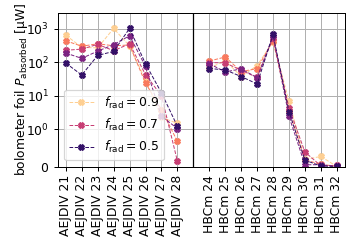

In [15]:
fig, ax = plt.subplots(figsize=(4,2.8))

skip_beg = 3
total_label = [*A_labels_QRB[skip_beg:], *A_labels_QSB[skip_beg:]]

total_label = [s[:-8] + s[-3:] for s in total_label]
tmp_x = np.array(range(1+len(total_label)))
tmp_x_tick = [*tmp_x[:len(A_labels_QRB[skip_beg:])], *tmp_x[-len(A_labels_QSB[skip_beg:]):]]
mW_fac = 1000000


for i, cpath in enumerate(cpaths):
    sum_QSB = QSB_all[cpath.stem][skip_beg:] * A_etendue_QSB[skip_beg:]
    sum_QRB = QRB_all[cpath.stem][skip_beg:] * A_etendue_QRB[skip_beg:]
    total_integrated = np.array([*sum_QRB, *sum_QSB])
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    label="$f_{\mathrm{rad}} =$" + str(frad)
    label = label if i%2==0 else None
    col=get_color(frad, diffval)
    
    y = mW_fac*total_integrated
    ax.errorbar(tmp_x, [*y[:len(A_labels_QRB[skip_beg:])], np.nan, *y[-len(A_labels_QSB[skip_beg:]):]],
                color=col, fmt="X--", ms=4.5,
               label=label, lw=0.8)
    

ax.set_xticks(tmp_x_tick)
ax.set_xticklabels(total_label, rotation=90)
ax.set_xlim(-0.5, len(total_label)+0.5)
# ax.set_title(f"Calculated absorbed {bolotype} foil power and relative error of absorbed power calculated by the sightline approach.")
# ax.set_ylabel("Collected Power in $\mathrm{mW}$")
#ax.legend(loc=1)
ax.set_yscale("symlog", linthresh=mW_fac*1e-6)
ax.set_ylim((0,mW_fac*3e-3))
ax.vlines(len(A_labels_QRB[skip_beg:]), 0, 1e9, color="k", lw=1)
ax.set_ylabel("bolometer foil $P_{\mathrm{absorbed}}$ [$\mathrm{\mu W}$]", va="center")

fig.tight_layout()
ax.grid()
ax.legend()